In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap

In [3]:
# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=512,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 512, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [4]:
sys.path.append('../../')
sys.path.append('/DMASS-analysis/measurements/code_py3/')
import esutil
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
os.chdir('../../DMASS-analysis/measurements/code_py3/')
print(os.getcwd())
from calling_catalogs import *
rootdir = '/users/PCON0003/warner785/DMASS-analysis/measurements/clustering/'
from ggl_mcal import run_ng_jk, run_nn_jk, run_nk_jk, compute_eix_jk, compute_Rgamma_jk, construct_jk, compute_jkcov, save_results

/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3


In [5]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(512, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=512
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [6]:
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
                              
    return data_R

## ---------------------------------------------

In [7]:
#print(np.sum(int(dmass_val['WEIGHT'])))

In [8]:
# import DMASS in validation region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_val, randoms = calling_lens_catalog('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200.fits')

random_val = uniform_random_on_sphere(dmass_val, size = int(np.sum(dmass_val['WEIGHT'])))
# applying LSS mask 
random_val = keepGoodRegion(random_val)

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 28441.7573735908
randoms= 5864645


In [9]:
print(dmass_val['HPIX_4096']) 

[71771941 71771626 71773248 ... 72968986 72905874 72968681]


In [10]:
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

In [11]:
random_val = appendColumn(random_val, value=np.ones(random_val.size), name='WEIGHT')
#randomsind_val = np.random.choice( random_val.size, size=int(random_val.size/3.) )
#random_val = random_val[randomsind_val]

In [12]:
print(random_val.size)

21731


In [11]:
# import DMASS in training region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_train, randoms = calling_lens_catalog('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200train.fits')

random_train = uniform_random_on_sphere(dmass_train, size = dmass_train.size)
# applying LSS mask 
random_train = keepGoodRegion(random_train)

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 20605.043776036357
randoms= 5864645


In [12]:
random_train = appendColumn(random_train, value=np.ones(random_train.size), name='WEIGHT')
randomsind_train = np.random.choice( random_train.size, size=int(random_train.size/3.) )
random_train = random_train[randomsind_train]

In [13]:
# calling CMASS

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [14]:
cmass = train_sample

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

In [40]:
# calling systematic maps
#sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )

# location of FWHM maps: /fs/scratch/PCON0003/warner785/bwarner/
# y3a2_g_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 
# y3a2_i_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz        
# y3a2_r_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz        
# y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 

# location of other maps: /fs/scratch/PCON0003/warner785/bwarner/y3/
# depending on different bands:

input_path = '/fs/scratch/PCON0003/warner785/bwarner/y3/band_z/'
#y3/band_z/
input_keyword = 'y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz'
sysMap = io.SearchAndCallFits(path = input_path, keyword = input_keyword)

#function for healpy to reduce resolution size of sys
sysMap = hp.pixelfunc.ud_grade(sysMap, 512, pess=True, order_in='RING', order_out=None, power=None, dtype=None)


Calling catalogs >>>
y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz
reading 1/1 /fs/scratch/PCON0003/warner785/bwarner/y3/band_z/y3a2_z_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz


TypeError: bad number of pixels

In [16]:
#all griz combined fracdet map

path = '/fs/scratch/PCON0003/warner785/bwarner/'
BAO_Fullmask = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')

print(BAO_Fullmask.dtype.names)
print(BAO_Fullmask['SIGNAL'])

('PIXEL', 'SIGNAL')
[1.      0.875   1.      ... 0.09375 0.8125  0.0625 ]


In [17]:
print(LSSGoldmask["SIGNAL"])

[1.     1.     1.     ... 1.     1.     0.9375]


[0.83776313 0.83776313 0.84078258 ... 0.8790409  0.8790409  0.85562736]
[ 907.31072306 2856.95460078 4383.39783874 4748.51034638 3904.30558257
 3409.57698662 2908.6977127  1911.1679054  1104.11546643  793.33494922
  540.9089493   392.55176882]


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


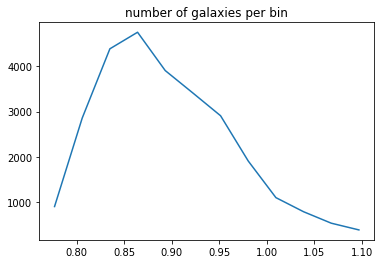

In [18]:
#Jack's method:
import matplotlib.pyplot as plt

#np.percentile()

index_mask = np.argsort(dmass_val['HPIX_4096'])
dmass_chron = dmass_val[index_mask] # ordered by hpix values

dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
#minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
#maximum = np.max(sysMap['SIGNAL'][dim_mask])
#print(minimum)
#print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

x = np.zeros(hp.nside2npix(4096))
x[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]

#systematic value at galaxy location:

sysval_gal = x[dmass_chron['HPIX_4096']]
print(sysval_gal)
h,_ = np.histogram(sysval_gal , bins=pbin, weights = dmass_chron["WEIGHT"]) # -- density of dmass sample, not gold sample
print(h)

# want this plotted:
#h/number_of_pixels_in_sysbin

#fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h)
#ax.legend(chi2_reduced)
plt.title('number of galaxies per bin')
fig.savefig('gal_bin.pdf')

In [20]:
# number of galaxies in each pixel:

# dmass catalog turned into healpix map
# counting number of galaxies in each healpix pixel 
# dividing healpix pixel area --- corresponding area to 4096 resolution -- to get number density (plus mask -- later) FRACDET

# 1) galaxy number counts and area for each healpix pixel -- match healpix with area map?

#bins of systematic signal
#print(pbin)

#compute how much area is in each bin. 
#you can get the first pass estimate of this by just doing a histogram of the signal column of the sysmap with the same bins.  

sys_signal = sysMap['SIGNAL'][dim_mask]
n,_ = np.histogram(sys_signal , bins=pbin )
print('area without weights:')
print(n)

#To do it properly you will need to:

#(A) make sure the mask you are using for the galaxies applied to the sysmap 
#print(LSSGoldmask.dtype.names)
#print(LSSGoldmask)

matched_sys = sysMap[dim_mask]
mask = np.zeros(hp.nside2npix(4096))
bao_mask = np.in1d(LSSGoldmask["PIXEL"], matched_sys["PIXEL"], assume_unique=False, invert=False)
mask[matched_sys["PIXEL"]] = matched_sys["SIGNAL"]

#some pixels were not in Goldmask, therefore these pixels = 0
# only include the signals of pixels of systematic within mask
BAO_sys = mask[LSSGoldmask["PIXEL"][bao_mask]]


#(B) add up the fractional coverage  (probably labelled fracgood or fracdet) in each “SIGNAL” bin, 
#rather than treating each pixel as 1. you can do this with the same histogram function by also passing the fracgood array 
#as the weights= argument 

area1,_ = np.histogram(BAO_sys , bins=pbin , weights = LSSGoldmask["SIGNAL"][bao_mask])
print('area with BAO mask:')
print(area1)

#*needs correction:
#only have taken out pixels with "0" 
# need frac_det array-- in BAO mask-- and apply the same BAO mask afterward to find area //

matched_sys2 = sysMap[dim_mask]
mask2 = np.zeros(hp.nside2npix(4096))
bao_mask2 = np.in1d(BAO_Fullmask["PIXEL"], matched_sys["PIXEL"], assume_unique=False, invert=False)
mask2[matched_sys["PIXEL"]] = matched_sys["SIGNAL"]
BAO_sys2 = mask[BAO_Fullmask["PIXEL"][bao_mask2]]

area,_ = np.histogram(BAO_sys2 , bins=pbin , weights = BAO_Fullmask["SIGNAL"][bao_mask2])
print('area with weights:')
print(area)

area without weights:
[ 40183 120061 184288 191530 164503 137079 116200  75008  45709  31280
  19933  13445]
area with BAO mask:
[ 39893.203 119244.33  182997.8   190209.97  163369.19  136142.19
 115407.5    74480.5    45402.375  31056.     19794.25   13356.   ]
area with weights:
[ 39895.406 119244.33  182999.6   190212.66  163369.25  136142.19
 115407.44   74481.31   45402.5    31056.     19794.375  13356.   ]


In [35]:
print(BAO_Fullmask["SIGNAL"][bao_mask2][10:100])
print(LSSGoldmask["SIGNAL"][bao_mask][10:100])

#for x in range(BAO_Fullmask.size):
#    if BAO_Fullmask["SIGNAL"][bao_mask2][x] !=1.0:
#        print(x)

[0.921875 1.       0.96875  0.984375 0.875    0.953125 0.84375  1.
 0.984375 1.       1.       1.       0.96875  1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 0.890625 1.       0.953125 1.       1.       1.       1.       1.
 0.984375 1.       1.       0.921875 1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       0.96875  1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       0.96875  0.890625 0.921875 1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.      ]
[0.921875 1.       0.96875  0.984375 0.875    0.953125 0.84375  1.
 0.984375 1.       1.       1.       0.96875  1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 0.890625 1.       0.953125 1.       1.   

In [44]:
#then do the number of galaxies divided by the area:

# h = number of galaxies
#print(h)

# number density in bins: h/area
#number_density = []
#for x in range(len(h)):
#    den = h[x]/area[x]
#    number_density.append(den)
    
#Details: So the idea here is, we don’t expect the number density of galaxies to change as we look at patches with different 
#survey property values.
#So when you make these histograms you are effectively splitting the survey footprint into patches of different 
#sysmap values and you can calculate the number density of objects in each patch.
    
#print(number_density)

#If we do see this density change as a function of the sysmap, we will have to correct for it with systematics 
#weights as Su did in her paper


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:479: RuntimeWarning: invalid value encountered in _ang2pix_nest
  return pixlib._ang2pix_nest(nside, theta, phi)


without weights:
[ 786 2226 3474 3477 2983 2551 2233 1336  856  538  380  253]
with weights:
[ 779.375   2209.8906  3453.5625  3455.5625  2964.3594  2534.25
 2217.9062  1326.5625   850.5625   533.8906   377.39062  251.32812]
area with weights:
[ 779.375   2209.8906  3453.5625  3455.5625  2964.3594  2534.25
 2217.9062  1326.5625   850.5625   533.8906   377.39062  251.32812]
number of random galaxies:  [ 799 2248 3514 3496 3004 2565 2247 1351  862  541  381  257]
randoms number density:  [1.0251804330392944, 1.0172449145531806, 1.0175000452431366, 1.0117021469008303, 1.0133724086675557, 1.0121337673868007, 1.013117664463951, 1.018421672555948, 1.013446983613785, 1.0133161637741812, 1.0095640293131287, 1.0225676095741374]
total_area:  20954.640625
total galaxies:  21265
total number density:  1.0148110091962028
[1.01021808 1.00239838 1.00264979 0.99693651 0.9985824  0.99736183
 0.99833137 1.00355797 0.99865588 0.99852697 0.9948296  1.00764339]
normalized error:  [0.03573895 0.02114181 0.0

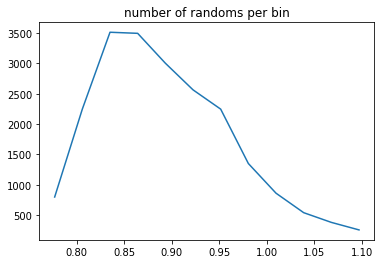

In [22]:
# now for randoms:

import matplotlib.pyplot as plt

#print(random_val.dtype.names)

# convert RA and DEC to PIXELS for randoms:
phi = random_val['RA'] * np.pi / 180.0
theta = ( 90.0 - random_val['DEC'] ) * np.pi/180.0
nside= 4096
random_pix = hp.ang2pix(nside,theta,phi,nest=True)
#print(random_pix)

index_ran_mask = np.argsort(random_pix)
random_chron = random_pix[index_ran_mask] # ordered by hpix values

dim_ran_mask = np.in1d(sysMap['PIXEL'], random_chron, assume_unique=False, invert=False)

minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
#minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
#print(minimum)
#print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

x = np.zeros(hp.nside2npix(4096))
x[sysMap['PIXEL'][dim_ran_mask]] = sysMap['SIGNAL'][dim_ran_mask]

#systematic value at galaxy location:

sysval_ran_gal = x[random_chron]
#print(sysval_ran_gal)
h_ran,_ = np.histogram(sysval_ran_gal , bins=pbin)
#print(h_ran)

# want this plotted:
#h/number_of_pixels_in_sysbin

#fracerr = 1/np.sqrt(h_ran) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h_ran)
#ax.legend(chi2_reduced)
plt.title('number of randoms per bin')
fig.savefig('random_bin.pdf')

sys_ran_signal = sysMap['SIGNAL'][dim_ran_mask]
n_ran,_ = np.histogram(sys_ran_signal , bins=pbin )
print('without weights:')
print(n_ran)

matched_ran_sys = sysMap[dim_ran_mask]
mask = np.zeros(hp.nside2npix(4096))
bao_mask_ran = np.in1d(LSSGoldmask["PIXEL"], matched_ran_sys["PIXEL"], assume_unique=False, invert=False)
mask[matched_ran_sys["PIXEL"]] = matched_ran_sys["SIGNAL"]

BAO_sys_ran = mask[LSSGoldmask["PIXEL"][bao_mask_ran]]

area1_ran,_ = np.histogram(BAO_sys_ran , bins=pbin , weights = LSSGoldmask["SIGNAL"][bao_mask_ran])
print('with weights:')
print(area1_ran)

matched_ran_sys2 = sysMap[dim_ran_mask]
mask2 = np.zeros(hp.nside2npix(4096))
bao_mask2_ran = np.in1d(BAO_Fullmask["PIXEL"], matched_ran_sys["PIXEL"], assume_unique=False, invert=False)
mask2[matched_ran_sys["PIXEL"]] = matched_ran_sys["SIGNAL"]
BAO_sys2_ran = mask[BAO_Fullmask["PIXEL"][bao_mask2_ran]]

area_ran,_ = np.histogram(BAO_sys2_ran , bins=pbin , weights = BAO_Fullmask["SIGNAL"][bao_mask2_ran])
print('area with weights:')
print(area_ran)

# h = number of galaxies
print("number of random galaxies: ", h_ran)

# number density in bins: h/area
number_density_ran = []
for x in range(len(h)):
    den_ran = h_ran[x]/area_ran[x]
    number_density_ran.append(den_ran)
    
print("randoms number density: ", number_density_ran)


total_area_ran = 0
#Normalize based on total number density of used footprint:
for x in range(len(area_ran)):
    total_area_ran += area_ran[x]

print("total_area: ", total_area_ran)

# total galaxies:
total_h_ran = 0
for x in range(len(h_ran)):
    total_h_ran += h_ran[x]

print("total galaxies: ", total_h_ran)

#normalization: 
total_num_density_ran = total_h_ran/total_area_ran

print("total number density: ", total_num_density_ran)

# apply normalization: 
#print(number_density)
norm_number_density_ran = number_density_ran/total_num_density_ran
print(norm_number_density_ran)

fracerr_ran = np.sqrt(h_ran) #1 / sqrt(number of randoms cmass galaxies in each bin)
fracerr_ran_norm = (fracerr_ran/area_ran)/total_num_density_ran
print("normalized error: ", fracerr_ran_norm)

In [23]:
print(h_ran)
print(area_ran)


[ 799 2248 3514 3496 3004 2565 2247 1351  862  541  381  257]
[ 779.375   2209.8906  3453.5625  3455.5625  2964.3594  2534.25
 2217.9062  1326.5625   850.5625   533.8906   377.39062  251.32812]


Text(0.5, 1.0, 'number of randoms versus dmass per bin')

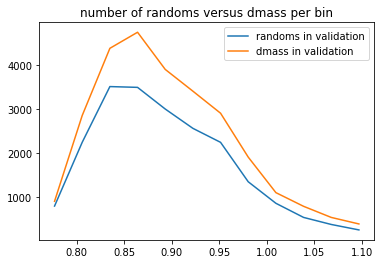

In [24]:
fig, ax = plt.subplots()
ax.errorbar( pcenter, h_ran, label = "randoms in validation")
ax.errorbar( pcenter, h, label = "dmass in validation")
plt.legend()
#ax.legend(chi2_reduced)
plt.title('number of randoms versus dmass per bin')

dmass number density:  [0.022742235468844227, 0.023958830123835057, 0.023953046828748843, 0.02496421868025269, 0.023898656464211278, 0.025044235363296592, 0.02520372842260215, 0.02565969692597857, 0.024318384812005423, 0.025545303619917557, 0.027326396984051357, 0.02939141725216026]
total_area:  1131361.046875
total galaxies:  27860.832830008625
normalized error:  [0.0306593  0.01820208 0.01469138 0.01471114 0.01553133 0.01741665
 0.01897678 0.02383467 0.02971903 0.036829   0.04771198 0.0602392 ]
total number density:  0.024625943156664883
[0.92350719 0.97291015 0.97267531 1.01373655 0.97046665 1.01698583
 1.02346246 1.04197824 0.9875108  1.03733301 1.1096589  1.19351438]


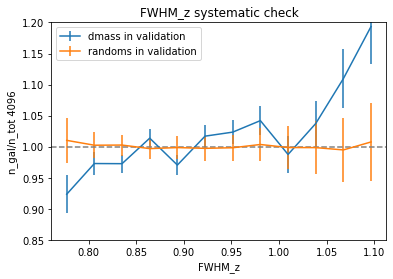

In [25]:
# *****Creating the figure******:

#Also, we usually normalize the plots to the total number density of the total footprint considered. 
#so that we expect the final result to be a flat line at y=1.

# number density in bins: h/area
number_density = []
for x in range(len(h)):
    den = h[x]/area[x]
    number_density.append(den)
    
print("dmass number density: ", number_density)

total_area = 0
#Normalize based on total number density of used footprint:
for x in range(len(area)):
    total_area += area[x]

print("total_area: ", total_area)

# total galaxies:
total_h = 0
for x in range(len(h)):
    total_h += h[x]

print("total galaxies: ", total_h)

#normalization: 
total_num_density = total_h/total_area


#errorbars: (how to define these)
fracerr = np.sqrt(h)
fracerr_norm = (fracerr/area)/total_num_density
print("normalized error: ", fracerr_norm)


print("total number density: ", total_num_density)

# apply normalization: 
#print(number_density)
norm_number_density = number_density/total_num_density
print(norm_number_density)

import matplotlib.pyplot as plt
#figure of systematics:

fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, norm_number_density, yerr=fracerr_norm, label = "dmass in validation")
ax.errorbar( pcenter, norm_number_density_ran, yerr=fracerr_ran_norm, label = "randoms in validation")
plt.legend()
plt.xlabel("FWHM_z")
plt.ylabel("n_gal/n_tot 4096")
plt.ylim(top=1.2)  # adjust the top leaving bottom unchanged
plt.ylim(bottom=0.85)
plt.axhline(y=1, color='grey', linestyle='--')
plt.title('FWHM_z systematic check')
fig.savefig('FWHM_z.pdf')

In [28]:
#check: fracdet working properly
#chi_2/degree of freedom (= number of bins) check to be close to 1 for normalized number density

x1=norm_number_density
x2=pcenter
err=fracerr_norm
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))
#chi_2/degree of freedom
print("chi_2/degree of freedom: ", chi2_reduced/chi2.size)

x1=norm_number_density_ran
x2=pcenter
err=fracerr_ran_norm
chi2_ran = (x1-x2)**2 / err **2 
chi2_reduced_ran = sum(chi2_ran)/chi2_ran.size
print("chi2_reduced for randoms: ",chi2_reduced_ran)
print("size: ",chi2_ran.size)
print("sum of chi2 for randoms: ",sum(chi2_ran))
#chi_2/degree of freedom
print("chi_2/degree of freedom for randoms: ", chi2_reduced_ran/chi2_ran.size)

#####if this doesnt work: reduce resolution to 512 for both (and systematic maps)

chi2_reduced:  31.50418590632995
size:  12
sum of chi2:  378.0502308759594
chi_2/degree of freedom:  2.625348825527496
chi2_reduced for randoms:  29.031608092991107
size:  12
sum of chi2 for randoms:  348.3792971158933
chi_2/degree of freedom for randoms:  2.4193006744159256


In [ ]:
# Before presenting new plots:

# Build description of plots to present results-- are these good results?
# Are these showing the right things
# Statistical power of new data (improved) can cause problems where there wasn't before in Y1
# Think about the science of the plots -- is there more we can get from them

# equation to test if data difference is noise or significant -- chi_2, difference(including noise), linear fit to trend (numpy) -- error on slope

# Interesting investigations into what data is saying

# Put plots in slides with Su's Y1 comparison
# look at Su's code in detail: verification 

# Parallel processing with research-- the science direction of coding, different problems to look into

In [ ]:
# add limits to narrow range of x axis
# use first and last percentile for limits instead of min max of x-axis
# np.percentile() -- for less noisy plot ** 2nd and 99th


#location of systematic maps:
#/global/cfs/cdirs/des/jelvinpo/sysmaps/y3/

In [40]:
# don't run: check

#dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

print(sysMap['PIXEL'][dim_mask])
print(dmass_chron['HPIX_4096'])

[    35370     35456     35458 ... 150977211 150977212 150977214]
[35370 35370 35456 ... 150977212 150977212 150977214]


In [11]:
# not this one

minimum = np.min(sysMap['PIXEL'])
maximum = np.max(sysMap['PIXEL'])
print(sysMap['SIGNAL'])
#np.min(sysMap['PIXEL'])
#np.max(sysMap['PIXEL'])
minpix = np.min(dmass_val['HPIX_4096'])
maxpix = np.max(dmass_val['HPIX_4096'])
#pbin = np.linspace(minimum, maximum, 13)
print(minpix)
print(maxpix)
#M, _ = np.histogram(dmass_val, bins=pbin) #shaded gray in plot

#number density of each
sysMaps_len = sysMap['PIXEL'].size
dmass_len = dmass_val['HPIX_4096'].size
print(dmass_len)

[1.0857818 1.0857818 1.0857818 ... 1.0808538 1.0808538 1.0808538]
35370
150977214
2741190


In [12]:
#unnecessay

#compare two arrays: mask first array
# sort dmass value to be chronilogical order:
index_mask = np.argsort(dmass_val['HPIX_4096'])

#print(index_mask)
#hpix_smallest = dmass_val['HPIX_4096'][2111516]

dmass_chron = dmass_val[index_mask] # ordered by hpix values

dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)
                    
#print(dim_mask)
#sys_pix = sysMap['PIXEL'][dim_mask]
#print(sys_pix)

In [12]:
print(dmass_chron['HPIX_4096'])

[35370 35370 35456 ... 150977212 150977212 150977214]


In [ ]:
# don't use this one

dmass_signal = []

for x in range(sysMaps_len):
    if sysMap['PIXEL'][x] > minpix or sysMap['PIXEL'][x] == minpix:
        if sysMap['PIXEL'][x] < maxpix or sysMap['PIXEL'][x] == maxpix:
            for y in range(dmass_len):
                if dmass_val['HPIX_4096'][y] == sysMap['PIXEL'][x]:
                    dmass_signal.append(sysMap['SIGNAL'][x])
                    
print(dmass_signal)

In [ ]:
# don't run this
# save the corresponding dmass signal
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_signal.fits', dmass_signal, overwrite=True)

In [ ]:
# notes
# number of galaxies in each pixel:

# dmass catalog turned into healpix map
# counting number of galaxies in each healpix pixel -- some numpy?
# dividing healpix pixel area --- corresponding area to 4096 resolution -- to get number density (plus mask -- later) FRACDET

# 1) galaxy number counts and area for each healpix pixel -- match healpix with area map?

dmass_counts = []
dmass_healpix = []
value_last = 0
arr = dmass_chron['HPIX_4096']

#check:
count = arr[arr==dmass_chron['HPIX_4096'][0]].shape[0]
print(count)

breakpoint()
#collections counter -- 
for x in range(len(dmass_chron['HPIX_4096'])):
    value = dmass_chron['HPIX_4096'][x]
    if value != value_last:
        count = arr[arr==value].shape[0]
    dmass_counts.append(count)
    dmass_healpix.append(value)

print(dmass_counts)
print(dmass_healpix)

2
--Return--
None
> <ipython-input-13-6303d079ef40>(18)<module>()
     16 print(count)
     17 
---> 18 breakpoint()
     19 #collections counter --
     20 for x in range(len(dmass_chron['HPIX_4096'])):



ipdb>  l


     13 
     14 #check:
     15 count = arr[arr==dmass_chron['HPIX_4096'][0]].shape[0]
     16 print(count)
     17 
---> 18 breakpoint()
     19 #collections counter --
     20 for x in range(len(dmass_chron['HPIX_4096'])):
     21     value = dmass_chron['HPIX_4096'][x]
     22     if value != value_last:
     23         count = arr[arr==value].shape[0]



ipdb>  n


    [... skipped 1 hidden frame]

> /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3346)run_code()
   3344             finally:
   3345                 # Reset our crash handler in place
-> 3346                 sys.excepthook = old_excepthook
   3347         except SystemExit as e:
   3348             if result is not None:



ipdb>  c


In [ ]:
# not run
# save the dmass counts and healpix arrays
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_counts.fits', dmass_counts, overwrite=True)

outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_healpix.fits', dmass_healpix, overwrite=True)

In [13]:
# 2) match healpix map with systematic maps (using same method as above)

dim_mask = np.in1d(sysMap['PIXEL'], dmass_healpix, assume_unique=False, invert=False)
                    
#print(dim_mask)
sys_pix = sysMap['PIXEL'][dim_mask]
print(sys_pix)

NameError: name 'dmass_healpix' is not defined

In [ ]:
# 3) array with: healpix pixel value, galaxy counts, area --- binned in signal histogram
# for all signal bins : total number counts in healpix pixels / totsl area of healpix pixels used in same bin --- number density
import matplotlib.pyplot as plt

# area: 6.24178e-08 square degrees ---- from github (without masking bad regions)

minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
maximum = np.max(sysMap['SIGNAL'][dim_mask])

print(minimum)
print(maximum)

pbin = np.linspace(minimum, maximum, 13)
pcenter = pbin[:-1] + 0.025

#another option: step through min max of pbin, bolean of pixel falls within, take average

N, _ = np.histogram(dmass_counts, bins=pbin)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, number_density, yerr=fracerr)
#ax.legend(chi2_reduced)
plt.title('Systematic Test')
fig.savefig('SystematicTest1.pdf')

# do the same with randoms
print(random_val.dtype.names)

In [ ]:
# take all objects in each bin of systematic value